4 Physical GPUs, 1 Logical GPU
15 30 4
[0 1]
15 68
(None, 1, 1) coeff (None, 10, 30) amplitude
Epoch 1/200
76/76 [==============================] - 4s 14ms/step - loss: 8.7965 - softmax_loss: 0.7097 - normalize_loss: 0.8497 - normalize3_loss: 0.8497 - softmax_acc: 0.5218
Epoch 2/200
76/76 [==============================] - 1s 14ms/step - loss: 8.1083 - softmax_loss: 0.6838 - normalize_loss: 0.6351 - normalize3_loss: 0.6351 - softmax_acc: 0.5592
Epoch 3/200
76/76 [==============================] - 1s 14ms/step - loss: 7.8628 - softmax_loss: 0.6886 - normalize_loss: 0.4886 - normalize3_loss: 0.4886 - softmax_acc: 0.5576
Epoch 4/200
76/76 [==============================] - 1s 14ms/step - loss: 7.7972 - softmax_loss: 0.6889 - normalize_loss: 0.4539 - normalize3_loss: 0.4539 - softmax_acc: 0.5610
Epoch 5/200
76/76 [==============================] - 1s 14ms/step - loss: 7.7853 - softmax_loss: 0.6906 - normalize_loss: 0.4396 - normalize3_loss: 0.4396 - softmax_acc: 0.5573
Epoch 6/200
76/76 [=

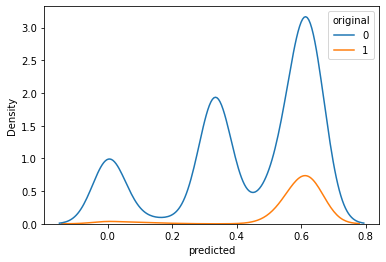

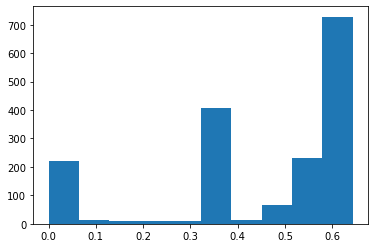

0.43844634628044765 Negative within positive
----------
3010 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
3013 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
3014 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
3015 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
3022 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
3024 val results 0.1046200840015273 1.6323971e-05 index 0 test results 0.3128390596745027 0.5599455 test result with val bias 0.20595922634605332
6
15 68
(None, 1, 1) coeff (None, 10, 30) amplitude
Epoch 1/200


In [17]:
from datetime import datetime,timedelta
from scipy.stats import iqr,skew,kurtosis,mode
from joblib import Parallel,delayed
import zipfile
import shutil
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score,r2_score,classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
seed = 100
tf.random.set_seed(seed)
np.random.seed(seed)
import os
import pandas as pd
import pickle
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split,LeavePGroupsOut
from keras.backend import expand_dims, repeat_elements
from keras.layers import Lambda
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,InputLayer,MaxPooling1D,Flatten,RepeatVector,Dense,Input,Activation,GRU,Bidirectional,LSTM
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score
import tensorflow_addons as tfa
import warnings
import functools
from tensorflow_addons.losses import metric_learning
import tensorflow as tf

# tf.config.run_functions_eagerly(False)
warnings.filterwarnings('ignore')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


def get_X_y_groups(n_lag=10):
    data = pickle.load(open(filepath_file.format(n_lag),'rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups


def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes


from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .7
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

class CenterLossLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes, n_features, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = n_classes
        self.n_features = n_features
        self.centers = tf.Variable(
            tf.zeros([n_classes, n_features]),
            name="centers",
            trainable=False,
            # in a distributed strategy, we want updates to this variable to be summed.
            aggregation=tf.VariableAggregation.MEAN,
            dtype=tf.float32
        )

    def call(self, x):
        # pass through layer
        return tf.identity(x)

    def get_config(self):
        config = super().get_config()
        config.update({"n_classes": self.n_classes, "n_features": self.n_features})
        return config


class CenterLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        centers_layer,
        alpha=0.9,
        update_centers=True,
        p = 95,
        name="center_loss",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.centers_layer = centers_layer
        self.centers = self.centers_layer.centers
        self.alpha = alpha
        self.update_centers = update_centers
        self.p = p
        
    def consistency_loss(self,labels,precise_embeddings):
        
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[lshape[0],1])),lshape[0],axis=0)
        mask_only_positive = tf.math.multiply(tf.cast(mask_for_equal,tf.float32),tf.cast(only_positive,tf.float32))
        pdist_matrix = metric_learning.pairwise_distance(
                    precise_embeddings, squared=False
                )
        # return tf.reduce_sum(pdist_matrix)
        positive_only_dist = tf.boolean_mask(pdist_matrix, tf.cast(mask_only_positive,tf.bool))

        distance_95 = tf.reshape(positive_only_dist,(-1,))
        # samples1 = tf.cast(tf.shape(labels)[0], tf.float32) #batch size
        # p =  2*(100. - self.p)/100.  #100% will return 0 elements, 0% will return all elements
        # samples = tf.cast(tf.math.floor(p * samples1), tf.int32)
        # values, indices = tf.math.top_k(distance_95, samples)
        # positive_dist_95th = tf.reduce_min(values)

        return tf.reduce_mean(distance_95)
        
    def compute_rare_loss(self,labels,precise_embeddings,positive_dist_95th):
        sparse_labels = tf.reshape(labels, (-1,))
        centers_batch = tf.gather(self.centers, tf.ones([tf.shape(sparse_labels)[0],],dtype=tf.int32))
        distance_to_positive_center = tf.norm(precise_embeddings-centers_batch,2,axis=1)
        distance_to_positive_center_smaller_than_95 = tf.where(distance_to_positive_center<=positive_dist_95th,1,0)
        negative_only = tf.math.logical_not(tf.cast(sparse_labels,tf.bool))
        negative_within_circle = tf.reduce_sum(tf.boolean_mask(distance_to_positive_center_smaller_than_95,negative_only))
        total_negative = tf.cast(tf.shape(sparse_labels)[0],tf.float32) - tf.reduce_sum(sparse_labels)
        rare_loss = tf.cast(negative_within_circle,tf.float32)/(total_negative+K.epsilon())
        return rare_loss
    
    def center_loss_positive_compute(self,labels,precise_embeddings,centers_batch):
        loss_row = tf.reduce_mean(tf.math.square(precise_embeddings - centers_batch),axis=1)
        loss_row_only_positive = tf.math.multiply(tf.cast(labels,tf.float32),loss_row)
        center_loss_positive = tf.reduce_sum(loss_row_only_positive)/(tf.reduce_sum(labels)+K.epsilon())
        return center_loss_positive
    
    def compute_positive_to_negative_loss(self,labels,precise_embeddings):
        sparse_labels = tf.reshape(labels, (-1,))
        centers_batch = tf.gather(self.centers, tf.ones([tf.shape(sparse_labels)[0],],dtype=tf.int32))
        distance_to_positive_center = tf.norm(precise_embeddings-centers_batch,2,axis=1)
        negative_only = tf.math.logical_not(tf.cast(sparse_labels,tf.bool))
        return tf.reduce_mean(tf.boolean_mask(distance_to_positive_center,negative_only))
    
    
    def call(self, sparse_labels, prelogits):
        sparse_labels = tf.reshape(sparse_labels, (-1,))
        # the reduction of batch dimension will be done by the parent class
        # center_loss = tf.keras.losses.mean_squared_error(prelogits, centers_batch)
        centers_batch = tf.gather(self.centers, tf.cast(sparse_labels,tf.int32))
        if self.update_centers and tf.cast(tf.reduce_sum(sparse_labels),tf.int32)<tf.shape(sparse_labels)[0]:
            diff = (1 - self.alpha) * (centers_batch - prelogits)
            updates = tf.scatter_nd(tf.cast(sparse_labels[:, None],tf.int32), diff, self.centers.shape)
            self.centers.assign_sub(updates)
        distance_95th = self.consistency_loss(sparse_labels,prelogits)
        # center_loss_positive = self.center_loss_positive_compute(sparse_labels,prelogits,centers_batch)        
        rare_loss = self.compute_rare_loss(sparse_labels,prelogits,positive_dist_95th=distance_95th)
        postive_to_negative_distance = self.compute_positive_to_negative_loss(sparse_labels,prelogits)
        return tf.square(rare_loss-.2)*10 + distance_95th
    
def get_model():
    n_t,n_f = train_feature.shape[1],train_feature.shape[2]
    print(n_t,n_f)
    x_input = Input(shape=(n_t,n_f))
    x_feature = Conv1D(10,1,activation='tanh')(x_input)
    # x_feature = Dropout(.2)(x_feature)
    x_feature = LSTM(10,activation='tanh',return_sequences=False)(x_feature)
    x_feature = Dropout(.2)(x_feature)
    x_feature = Flatten()(x_feature)
    x_feature = Dense(10,activation='relu')(x_feature)
    
    n_sf = train_static.shape[1]
    x_input_static = Input(shape=(n_sf))
    x_static = Dense(10,activation='relu')(x_input_static)
    # x_static = Dense(10,activation='relu')(x_static)
    n_timesteps = train_stress.shape[-2]
    n_episodes_stress,n_episodes_quit,n_episodes_activity,n_episodes_smoking = train_stress.shape[1],train_quit.shape[1],train_activity.shape[1],train_smoking.shape[1]
    
    x_alpha_stress = Dense(1,activation='sigmoid',name='alpha_stress')(x_static)
    x_alpha_stress = RepeatVector(n_timesteps)(x_alpha_stress)
    x_alpha_stress = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_stress, 1))(x_alpha_stress)
    
    x_alpha_quit = Dense(1,activation='sigmoid',name='alpha_quit')(x_static)
    x_alpha_quit = RepeatVector(n_timesteps)(x_alpha_quit)
    x_alpha_quit = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_quit, 1))(x_alpha_quit)
    
    x_alpha_activity = Dense(1,activation='sigmoid',name='alpha_activity')(x_static)
    x_alpha_activity = RepeatVector(n_timesteps)(x_alpha_activity)
    x_alpha_activity = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_activity, 1))(x_alpha_activity)
    
    x_alpha_smoking = Dense(1,activation='sigmoid',name='alpha_smoking')(x_static)
    x_alpha_smoking = RepeatVector(n_timesteps)(x_alpha_smoking)
    x_alpha_smoking = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_smoking, 1))(x_alpha_smoking)

    n_dim = 3
    x_stress = Input(shape=(n_episodes_stress,n_timesteps,n_dim))
    stress_alpha_time = tf.math.multiply(x_alpha_stress[:,:,:,0]*-1,x_stress[:,:,:,0])
    stress_alpha_time_exp = tf.math.exp(stress_alpha_time)

    x_stress_amplitude = x_stress[:,:,:,1]
    stress_amplitude_coeff = Dense(1,activation='relu',name='amplitude_stress')(x_static)
    stress_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(stress_amplitude_coeff)
    print(stress_amplitude_coeff.shape,'coeff',x_stress_amplitude.shape,'amplitude')
    x_stress_amplitude = tf.math.multiply(x_stress_amplitude,stress_amplitude_coeff)
    x_stress_duration = x_stress[:,:,:,2]
    stress_duration_coeff = Dense(1,activation='sigmoid',name='duration_stress')(x_static)
    stress_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(stress_duration_coeff)
    x_stress_duration = tf.math.multiply(x_stress_duration,stress_duration_coeff)
    x_stress_all = tf.math.add(x_stress_amplitude,x_stress_duration)
    stress_alpha_time_exp_amplitude = tf.math.multiply(stress_alpha_time_exp,x_stress_all)
    stress_final = tf.math.reduce_sum(stress_alpha_time_exp_amplitude,axis=1)
    stress_final = Lambda(lambda x: expand_dims(x, axis=2))(stress_final)
    # stress_final = LSTM(10,activation='tanh',return_sequences=True)(stress_final)
    
    
    
    x_quit = Input(shape=(n_episodes_quit,n_timesteps,n_dim))

    x_smoking = Input(shape=(n_episodes_smoking,n_timesteps,n_dim))
    smoking_alpha_time = tf.math.multiply(x_alpha_smoking[:,:,:,0]*-1,x_smoking[:,:,:,0])
    smoking_alpha_time_exp = tf.math.exp(smoking_alpha_time)
    x_smoking_amplitude = x_smoking[:,:,:,1]
    smoking_amplitude_coeff = Dense(1,activation='sigmoid',name='amplitude_smoking')(x_static)
    smoking_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(smoking_amplitude_coeff)
    x_smoking_amplitude = tf.math.multiply(x_smoking_amplitude,smoking_amplitude_coeff)
    x_smoking_duration = x_smoking[:,:,:,2]
    smoking_duration_coeff = Dense(1,activation='sigmoid',name='duration_smoking')(x_static)
    smoking_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(smoking_duration_coeff)
    x_smoking_duration = tf.math.multiply(x_smoking_duration,smoking_duration_coeff)
    x_smoking_all = tf.math.add(x_smoking_amplitude,x_smoking_duration)
    smoking_alpha_time_exp_amplitude = tf.math.multiply(smoking_alpha_time_exp,x_smoking_all)
    smoking_final = tf.math.reduce_sum(smoking_alpha_time_exp_amplitude,axis=1)
    smoking_final = Lambda(lambda x: expand_dims(x, axis=2))(smoking_final)
    # smoking_final = LSTM(10,activation='tanh',return_sequences=True)(smoking_final)

    
    
    x_activity = Input(shape=(n_episodes_activity,n_timesteps,n_dim))
    activity_alpha_time = tf.math.multiply(x_alpha_activity[:,:,:,0]*-1,x_activity[:,:,:,0])
    activity_alpha_time_exp = tf.math.exp(activity_alpha_time)
    x_activity_amplitude = x_activity[:,:,:,1]
    activity_amplitude_coeff = Dense(1,activation='sigmoid',name='amplitude_activity')(x_static)
    activity_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(activity_amplitude_coeff)
    x_activity_amplitude = tf.math.multiply(x_activity_amplitude,activity_amplitude_coeff)
    x_activity_duration = x_activity[:,:,:,2]
    activity_duration_coeff = Dense(1,activation='sigmoid',name='duration_activity')(x_static)
    activity_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(activity_duration_coeff)
    x_activity_duration = tf.math.multiply(x_activity_duration,activity_duration_coeff)
    x_activity_all = tf.math.add(x_activity_amplitude,x_activity_duration)
    activity_alpha_time_exp_amplitude = tf.math.multiply(activity_alpha_time_exp,x_activity_all)
    activity_final = tf.math.reduce_sum(activity_alpha_time_exp_amplitude,axis=1)
    activity_final = Lambda(lambda x: expand_dims(x, axis=2))(activity_final)
    # activity_final = LSTM(10,activation='tanh',return_sequences=True)(activity_final)
    
    
    x_episode = tf.concat([activity_final, stress_final, smoking_final],2)
    x_episode = LSTM(10,activation='tanh',return_sequences=False)(x_episode)
    x_episode = Dropout(.03)(x_episode)
    x_episode = Flatten()(x_episode)
    x_episode = Dense(10,activation='relu')(x_episode)

    # merged_all = tf.concat([x_feature,x_episode],1)
    # print(merged.shape,'concatenated shape')
    merged_all = x_episode
    
    merged1 = Dense(10,activation='relu',name='normalize2')(merged_all)
    merged1 = Lambda(lambda x: K.l2_normalize(x,axis=1))(merged1)
    center_layer1 = CenterLossLayer(n_classes=2, n_features=10,name='normalize3')
    merged1 = center_layer1(merged1)
    
    # merged = Dense(5,activation='relu',name='norma')(merged1)
    # merged = Dense(2,activation='relu',name='normalize1')(merged)
    # merged = Lambda(lambda x: K.l2_normalize(x,axis=1))(merged)
    center_layer = CenterLossLayer(n_classes=2, n_features=10,name='normalize')
    merged = center_layer(merged1)
    # merged = Dense(10,activation='relu')(merged)
    # 
    # output1 = Dense(2,activation='relu')(merged)
    output = Dense(2,activation='softmax',name='softmax')(merged)
    # output = Activation('softmax',name='softmax')(merged)
    # output = Dense(2,activation='softmax')(merged)
    # output = Reshape((-1,1))(output)
#     output = Activation('softmax',name='softmax')(output)
    model = Model(inputs=[x_input,x_input_static,x_stress,x_activity,x_smoking,x_quit], outputs=[output,merged,merged1])
    # myloss = get_center_loss(num_classes=2,feature_dim=merged.shape[-1],alpha=.9)
    myloss = CenterLoss(centers_layer=center_layer)
    myloss1 = CenterLoss(centers_layer=center_layer1)
    
    model.compile(
        loss={'softmax':tf.losses.SparseCategoricalCrossentropy(),'normalize':myloss,'normalize3':myloss1},
        loss_weights = {'softmax':10,'normalize':0,'normalize3':2},
        metrics={'softmax':['acc']},
        optimizer='adam'
    )
    return model


from sklearn.preprocessing import OneHotEncoder
def get_X_y_groups(n_lag=10):
    data = pickle.load(open(filepath_file.format(n_lag),'rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    print(data['label'].unique())
    # y =  OneHotEncoder().fit_transform(data['label'].values.reshape(-1,1)).todense()
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups


from sklearn.metrics import roc_auc_score
# filepath_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check_2'


for n_lag in [15]:
    for obs in [30]:
        for n_cluster in [4]:
            # try:
            if not os.path.isfile('./data/output_final_all/result_only_episode_lag_{}_obs_{}_triplet_loss_cluster_{}.p'.format(n_lag,obs,n_cluster)):
                print(n_lag,obs,n_cluster,'done')
                continue
            else:
                print(n_lag,obs,n_cluster)
                filepath_file = './data/episode_encoded_lagged_data_with_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
                use_standardization = True
                all_data = []
                columns = ['alpha_stress','alpha_smoking','alpha_activity']
                amplitude_duration_data = []
                amplitude_duration_columns = ['amplitude_stress','duration_stress'] 
                data_cluster = pickle.load(open(filepath_file.format(n_lag),'rb'))
                temp = data_cluster.groupby(['user','cluster_label']).count().index.values
                users = np.array([a[0] for a in temp])
                labels = np.array([a[1] for a in temp])
                cluster_dict = {}
                for i,a in enumerate(users):
                    cluster_dict[a] = labels[i]
                n_groups = len(np.unique(users))
                # n_groups = 20
                X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups = get_X_y_groups(n_lag)
                # y[y<0] = 0
                X_feature = np.nan_to_num(X_feature)
                y = np.float32(y)
                indexes = get_train_test_indexes(groups,n_groups_split = 10,n_val_groups=5)
                final_y_time = []
                final_probs = []
                final_y = []
                final_groups = []
                bias_dict = {}
                val_results = {}
                for kk,yyyy in enumerate(indexes[1:]):
                    train_index,test_index,val_index = yyyy
                    
                    X_feature_train,X_feature_test = X_feature[train_index],X_feature[test_index]
                    X_static_train,X_static_test = X_static[train_index],X_static[test_index]
                    X_stress_episode_train,X_stress_episode_test = X_stress_episode[train_index], X_stress_episode[test_index]
                    X_quit_episode_train,X_quit_episode_test = X_quit_episode[train_index], X_quit_episode[test_index]
                    X_activity_episode_train,X_activity_episode_test = X_activity_episode[train_index], X_activity_episode[test_index]
                    X_smoking_episode_train,X_smoking_episode_test = X_smoking_episode[train_index], X_smoking_episode[test_index]
                    y_train,y_test,groups_train,groups_test,time_train,time_test = y[train_index],y[test_index],groups[train_index],groups[test_index],y_time[train_index],y_time[test_index]
                    
                    X_feature_val,X_static_val,X_stress_episode_val,X_quit_episode_val,\
                    X_activity_episode_val,X_smoking_episode_val,y_val,groups_val,time_val = X_feature[val_index],X_static[val_index],X_stress_episode[val_index],X_quit_episode[val_index],\
                                                                                            X_activity_episode[val_index],X_smoking_episode[val_index],y[val_index],groups[val_index],y_time[val_index]
                    
                    # y_train = np.array(y_train).reshape(len(y_train),-1)
                    positive_train_index = np.where(y_train==1)[0]
                    negative_train_index = np.where(y_train==0)[0]
                    len_positive = len(positive_train_index)
                    n_iters = 1
                    test_preds = []
                    bias_pred = []
                    for i,n_iter in enumerate(range(n_iters)):
                        np.random.seed(np.random.randint(109))
                        indexes_sampled = np.array(list(positive_train_index)+list(np.random.choice(negative_train_index,len_positive,replace=False)))
                        train_feature = X_feature_train[indexes_sampled]
                        train_static = X_static_train[indexes_sampled]
                        train_stress = X_stress_episode_train[indexes_sampled]
                        train_quit = X_quit_episode_train[indexes_sampled]
                        train_activity = X_activity_episode_train[indexes_sampled]
                        train_smoking = X_smoking_episode_train[indexes_sampled]
                        train_y = y_train[indexes_sampled]
                        from keras import backend as K
                        K.clear_session()
                        model = get_model()
                        # model.summary()

                        filepath = './models/lag_'+str(n_lag)+'_iter_'+str(n_iter)+'_temp3.hdf5'
                        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
                        es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=60)
                        callbacks_list = [es,checkpoint]
                        train_feature,val_feature,train_static,val_static,train_stress,val_stress, \
                        train_smoking,val_smoking,train_quit,val_quit,train_activity,val_activity, \
                        train_y,val_y = train_test_split(
                                                        train_feature,
                                                        train_static,
                                                        train_stress,
                                                        train_smoking,
                                                        train_quit,
                                                        train_activity,
                                                        train_y,
                                                        test_size=.15,
                                                        stratify=train_y
                                                        )
                        val_feature = np.concatenate([val_feature,X_feature_val])
                        val_static = np.concatenate([val_static,X_static_val])
                        val_stress = np.concatenate([val_stress,X_stress_episode_val])
                        val_activity = np.concatenate([val_activity,X_activity_episode_val])
                        val_smoking = np.concatenate([val_smoking,X_smoking_episode_val])
                        val_quit = np.concatenate([val_quit,X_quit_episode_val])
                        val_y = np.array(list(val_y)+list(y_val))

                        # K.set_value(model.optimizer.learning_rate, 0.0001)
                        model.fit([train_feature,train_static,train_stress,train_activity,train_smoking,train_quit],train_y,
                                                epochs=200, batch_size=50,
                                                            verbose=1,callbacks=callbacks_list,shuffle=True)
                        # model.get_layer('normalize').centers
                        
                        # model.fit([train_feature,train_static,train_stress,train_activity,train_smoking,train_quit],train_y,
                        # validation_data=([val_feature,val_static,val_stress,val_activity,val_smoking,val_quit],val_y), epochs=30, batch_size=80,
                        #             verbose=1,callbacks=callbacks_list,shuffle=True)
                        if os.path.isfile(filepath):
                            model.load_weights(filepath)
                        # temp_model = Model(model.input[1],[model.get_layer(c).output for c in columns+amplitude_duration_columns])
                        # X_static_test_new = np.hstack((X_static_test, np.zeros((X_static_test.shape[0], 3), dtype=X_static_test.dtype)))
                        # X_static_test_new[:,-3] = np.mean(X_stress_episode_test[:,:,0,1],axis=1)
                        # X_static_test_new[:,-2] = np.mean(X_stress_episode_test[:,:,0,2],axis=1)
                        # X_static_test_new[:,-1] = [cluster_dict[a] for a in groups_test]
                        # X_static_test_new = np.unique(X_static_test_new,axis=0)
                        # pred_list = list(zip(*[list(a.reshape(-1)) for a in temp_model.predict(X_static_test_new[:,:-3])]))
                        # for ii,a in enumerate(pred_list):
                        #     for jj,c_name in enumerate(columns+amplitude_duration_columns):
                        #         all_data.append([a[jj],
                        #                         c_name,
                        #                         X_static_test_new[ii][-1],
                        #                         a[-2]*X_static_test_new[ii][-3],
                        #                         a[-1]*X_static_test_new[ii][-2],
                        #                         n_lag,
                        #                         kk,
                        #                         i])

                        test_preds.append(model.predict([X_feature_test,X_static_test,X_stress_episode_test,
                                                    X_activity_episode_test,X_smoking_episode_test,X_quit_episode_test])[0][:,1])
                        bias_pred.append(model.predict([X_feature_val,X_static_val,X_stress_episode_val,X_activity_episode_val,
                                                        X_smoking_episode_val,X_quit_episode_val])[0][:,1])
                        
                    from sklearn.preprocessing import MinMaxScaler
                    y_test_pred = np.concatenate([a.reshape(-1,1) for a in test_preds],axis=1)
                    y_test_check = np.int64(np.array(y_test).reshape(-1))
                    import seaborn as sns
                    for lll in np.arange(y_test_pred.shape[-1]):
                        df_check = pd.DataFrame({'original':y_test_check,'predicted':y_test_pred[:,lll]})
                        plt.figure()
                        sns.kdeplot(data=df_check,x='predicted',hue='original')
                        plt.show()
                        # df_check['predicted']
                        plt.figure()
                        plt.hist(y_test_pred[:,lll])
                        plt.show()
                        distance_80th = np.percentile(y_test_pred[y_test_check==1,lll],20)
                        negative_within_circle = y_test_pred[np.where((y_test_check==0)&(y_test_pred[:,lll]>distance_80th))[0],lll]
                        print(negative_within_circle.shape[0]/np.where(y_test_check==0)[0].shape[0],'Negative within positive')
                        print('-'*10)
                    bias_pred = np.concatenate([a.reshape(-1,1) for a in bias_pred],axis=1)
                    # print(roc_auc_score(y_test,y_test_pred))
                    final_y_time.extend(list(time_test))
                    final_probs.extend(list(y_test_pred))
                    final_y.extend(list(y_test))
                    final_groups.extend(list(groups_test))
                    for group_b in np.unique(groups_test):
                        bias_dict[group_b] = []
                        for kkk in range(bias_pred.shape[1]):
                            f1,bias = f1Bias_scorer_CV(bias_pred[:,kkk].reshape(-1),np.int64(y_val.reshape(-1)))
                            
                            f1_test, bias_test = f1Bias_scorer_CV(y_test_pred[:,kkk],np.int64(y_test.reshape(-1)))
                            # plt.hist(y_test_pred[:,kkk],100)
                            # plt.show()
                            if kkk==0:
                                print(group_b,
                                'val results',
                                f1,bias,
                                'index',kkk,
                                'test results',
                                f1_test,bias_test,
                                'test result with val bias',
                                f1_score(y_test,np.array(y_test_pred[:,kkk]>=bias,dtype=np.int64)))
                            
                            bias_dict[group_b].append(bias)
                        val_results[group_b] = [time_val,bias_pred,y_val,groups_val]
                    print(len(np.unique(final_groups)))
                    # print(bias_dict)
                final_y_time,final_probs,final_y,final_groups = np.array(final_y_time),np.array(final_probs),np.array(final_y),np.array(final_groups)
                pickle.dump([final_y_time,final_probs,final_y,final_groups,bias_dict,val_results],open('./data/output_final_all/result_only_episode_lag_{}_obs_{}_triplet_loss_cluster__{}.p'.format(n_lag,obs,n_cluster),'wb'))
            # except:
            #     pass

In [ ]:
import seaborn as sns
for lll in np.arange(y_test_pred.shape[-1]):
    df_check = pd.DataFrame({'original':y_test_check,'predicted':y_test_pred[:,lll]})
    plt.figure()
    # plt.hist(y_test_pred[:,lll])
    sns.kdeplot(data=df_check,x='predicted',hue='original')
    plt.show()
    distance_80th = np.percentile(y_test_pred[y_test_check==1,lll],20)
    negative_within_circle = y_test_pred[np.where((y_test_check==0)&(y_test_pred[:,lll]>=distance_80th))[0],lll]
    print(distance_80th,negative_within_circle.shape[0]/np.where(y_test_check==0)[0].shape[0],'Negative within positive')
    print('-'*10)

In [ ]:
df_check['predicted']
# .plot(kind='hist')
# plot(kind='hist')

In [ ]:



from tensorflow_addons.losses import metric_learning
import tensorflow as tf
import numpy as np
num_classes = 2
feature_dim = 20
alpha = .2
# centers = K.zeros([num_classes, feature_dim])
centers = tf.Variable(
            tf.zeros([num_classes, feature_dim]),
            name="centers",
            trainable=False,
            # in a distributed strategy, we want updates to this variable to be summed.
            aggregation=tf.VariableAggregation.SUM,
            dtype=tf.float32
        )
features = tf.cast(tf.convert_to_tensor(np.random.randn(10,feature_dim)),tf.float32)
labels = tf.convert_to_tensor(np.array([0]*5+[1]*5))



In [ ]:





precise_embeddings = tf.cast(tf.convert_to_tensor(np.random.randn(10,feature_dim)),tf.float32)
labels = tf.convert_to_tensor(np.array([0]*3+[1]*7))

lshape = tf.shape(labels)
labels = tf.reshape(labels, [lshape[0], 1])
mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[10,1])),10,axis=0)
mask_only_positive = tf.math.multiply(tf.cast(mask_for_equal,tf.float32),tf.cast(only_positive,tf.float32))

# mask_negative_to_positive = tf.math.logical_and(only_positive,tf.math.logical_not(tf.cast(mask_only_positive,tf.bool)))

pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )
# positive_only_dist = tf.math.multiply(pdist_matrix,mask_only_positive)
# consistency = tf.reduce_sum(positive_only_dist)/tf.reduce_sum(mask_only_positive)

positive_only_dist = tf.boolean_mask(pdist_matrix, tf.cast(mask_only_positive,tf.bool))

distance_95 = tf.reshape(positive_only_dist,(-1,))
samples1 = tf.cast(tf.shape(labels)[0], tf.float32) #batch size
p = 80
p =  2*(100. - p)/100.  #100% will return 0 elements, 0% will return all elements
samples = tf.cast(tf.math.floor(p * samples1), tf.int32)
values, indices = tf.math.top_k(distance_95, samples)
positive_dist_95th = tf.reduce_min(values)

sparse_labels = tf.reshape(labels, (-1,))
centers_batch = tf.gather(centers, tf.cast(sparse_labels,tf.int32))
diff = (1 - .9) * (centers_batch - precise_embeddings)
updates = tf.scatter_nd(tf.cast(sparse_labels[:, None],tf.int32), diff, centers.shape)
centers.assign_add(updates)
centers_batch = tf.gather(centers, tf.ones(sparse_labels.shape,dtype=tf.int32))
distance_to_positive_center = tf.norm(precise_embeddings-centers_batch,2,axis=1)


In [ ]:
distance_to_positive_center_smaller_than_95 = tf.where(distance_to_positive_center<positive_dist_95th,1,0)
negative_only = tf.math.logical_not(tf.cast(sparse_labels,tf.bool))
negative_within_circle = tf.reduce_sum(tf.boolean_mask(distance_to_positive_center_smaller_than_95,negative_only))
total_negative = tf.shape(sparse_labels)[0] - tf.reduce_sum(sparse_labels)
rare_loss = negative_within_circle/(total_negative+K.epsilon())


In [ ]:
# tf.norm(distance_to_positive_center,2,axis=1)


In [ ]:
sparse_labels = tf.reshape(labels, (-1,))
centers_batch = tf.gather(centers, tf.cast(sparse_labels,tf.int32))
diff = (1 - .9) * (centers_batch - precise_embeddings)
updates = tf.scatter_nd(tf.cast(sparse_labels[:, None],tf.int32), diff, centers.shape)

In [ ]:
centers

In [ ]:
centers.assign_add(updates)

In [ ]:
centers

In [ ]:
# tf.math.multiply(pdist_matrix,mask_only_positive)
# tf.reduce_sum(mask_only_positive)
consistency

In [ ]:
pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )


In [ ]:
adjacency = tf.math.equal(labels, tf.transpose(labels))
adjacency_not = tf.math.logical_not(adjacency)
batch_size = tf.size(labels)

In [ ]:
# tf.math.multiply(adjacency,tf.cast(labels,tf.bool))
mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[10,1])),10,axis=0)


In [ ]:
# tf.math.multiply(tf.reshape(tf.cast(labels,tf.bool),[10,1]),mask_for_positive)
tf.math.multiply(tf.cast(mask_for_equal,tf.int32),tf.cast(only_positive,tf.int32))

In [ ]:
pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])

In [ ]:
pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
mask = tf.math.logical_and(
    tf.tile(adjacency_not, [batch_size, 1]),
    tf.math.greater(
        pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
    ),
)
mask_final = tf.reshape(
    tf.math.greater(
        tf.math.reduce_sum(
            tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
        ),
        0.0,
    ),
    [batch_size, batch_size],
)
mask_final = tf.transpose(mask_final)


In [ ]:
mask_final